In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

In [2]:
from LSTMFeature import LSTMFeatureExtractor

In [3]:
# --- 1. Tải và Tiền xử lý Dữ liệu ---
print("--- 1. Tải và Tiền xử lý Dữ liệu ---")
df = pd.read_csv("../dataset/ECL.csv")
original_df = df.copy()

--- 1. Tải và Tiền xử lý Dữ liệu ---


In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Điền khuyết bằng nội suy theo thời gian
print("Điền khuyết bằng nội suy theo thời gian...")
df = df.interpolate(method='time')

# Chuẩn hóa dữ liệu
print("Chuẩn hóa dữ liệu...")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
print("Tiền xử lý hoàn tất.")

Điền khuyết bằng nội suy theo thời gian...
Chuẩn hóa dữ liệu...
Tiền xử lý hoàn tất.


In [5]:
# --- 2. Lựa chọn Đặc trưng ---
print("\n--- 2. Lựa chọn Đặc trưng ---")
correlations = df.corr()['MT_001'].abs().sort_values(ascending=False)
top_features = correlations.drop('MT_001').head(50).index.tolist()
selected_columns = top_features + ['MT_001']
reduced_df = scaled_df[selected_columns].astype(np.float32)
print(f"Đã chọn {len(selected_columns) - 1} đặc trưng có tương quan cao nhất với 'MT_001'.")



--- 2. Lựa chọn Đặc trưng ---
Đã chọn 50 đặc trưng có tương quan cao nhất với 'MT_001'.


In [6]:
# --- 3. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo một bước) ---
print("\n--- 3. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo một bước) ---")
def create_supervised_data(data, target_column='MT_001', window_size=24):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

X_single_step, y_single_step = create_supervised_data(reduced_df, window_size=24)



--- 3. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo một bước) ---


In [7]:
print("Shape of X (dự báo một bước):", X_single_step.shape)
print("Shape of y (dự báo một bước):", y_single_step.shape)


Shape of X (dự báo một bước): (26280, 24, 51)
Shape of y (dự báo một bước): (26280,)


In [8]:
# --- 4. Trích xuất Đặc trưng bằng LSTM ---
print("\n--- 4. Trích xuất Đặc trưng bằng LSTM ---")
# Sử dụng lớp đã import từ file riêng
lstm_extractor = LSTMFeatureExtractor(input_size=X_single_step.shape[2])
lstm_extractor.eval()

with torch.no_grad():
    features_single_step = lstm_extractor(torch.tensor(X_single_step, dtype=torch.float32)).numpy()
print("Đặc trưng LSTM cho dự báo một bước đã được trích xuất.")
print("Shape of features (dự báo một bước):", features_single_step.shape)



--- 4. Trích xuất Đặc trưng bằng LSTM ---
Đặc trưng LSTM cho dự báo một bước đã được trích xuất.
Shape of features (dự báo một bước): (26280, 64)


In [9]:
# --- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) trên toàn bộ dữ liệu ---
print("\n--- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) trên toàn bộ dữ liệu ---")
xgb_model_single_step = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)
xgb_model_single_step.fit(features_single_step, y_single_step)
print("Mô hình XGBoost (dự báo một bước) đã được huấn luyện trên toàn bộ dữ liệu.")

y_pred_single_step_scaled = xgb_model_single_step.predict(features_single_step)
mse_single_step_scaled = mean_squared_error(y_single_step, y_pred_single_step_scaled)
mae_single_step_scaled = mean_absolute_error(y_single_step, y_pred_single_step_scaled)

print(f"MSE (Dự báo một bước, dữ liệu CHUẨN HÓA): {mse_single_step_scaled:.4f}")
print(f"MAE (Dự báo một bước, dữ liệu CHUẨN HÓA): {mae_single_step_scaled:.4f}")


--- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) trên toàn bộ dữ liệu ---
Mô hình XGBoost (dự báo một bước) đã được huấn luyện trên toàn bộ dữ liệu.
MSE (Dự báo một bước, dữ liệu CHUẨN HÓA): 0.2405
MAE (Dự báo một bước, dữ liệu CHUẨN HÓA): 0.3499


In [10]:
# --- Đảo ngược chuẩn hóa cho kết quả dự báo một bước ---
print("\n--- Đảo ngược chuẩn hóa cho kết quả dự báo một bước ---")
mt_001_col_idx = scaled_df.columns.get_loc('MT_001')
dummy_array_for_inverse = np.zeros((y_pred_single_step_scaled.shape[0], scaled_df.shape[1]))
dummy_array_for_inverse[:, mt_001_col_idx] = y_pred_single_step_scaled
y_pred_single_step_inverted = scaler.inverse_transform(dummy_array_for_inverse)[:, mt_001_col_idx]

original_y_single_step = df['MT_001'].iloc[X_single_step.shape[1]:].values
original_y_single_step = original_y_single_step[:y_pred_single_step_inverted.shape[0]]

mse_single_step_inverted = mean_squared_error(original_y_single_step, y_pred_single_step_inverted)
mae_single_step_inverted = mean_absolute_error(original_y_single_step, y_pred_single_step_inverted)

print(f"MSE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): {mse_single_step_inverted:.4f}")
print(f"MAE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): {mae_single_step_inverted:.4f}")



--- Đảo ngược chuẩn hóa cho kết quả dự báo một bước ---
MSE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): 157.0036
MAE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): 8.9402



--- 8. Vẽ sơ đồ so sánh dữ liệu thực và dự báo (Dự báo một bước) ---


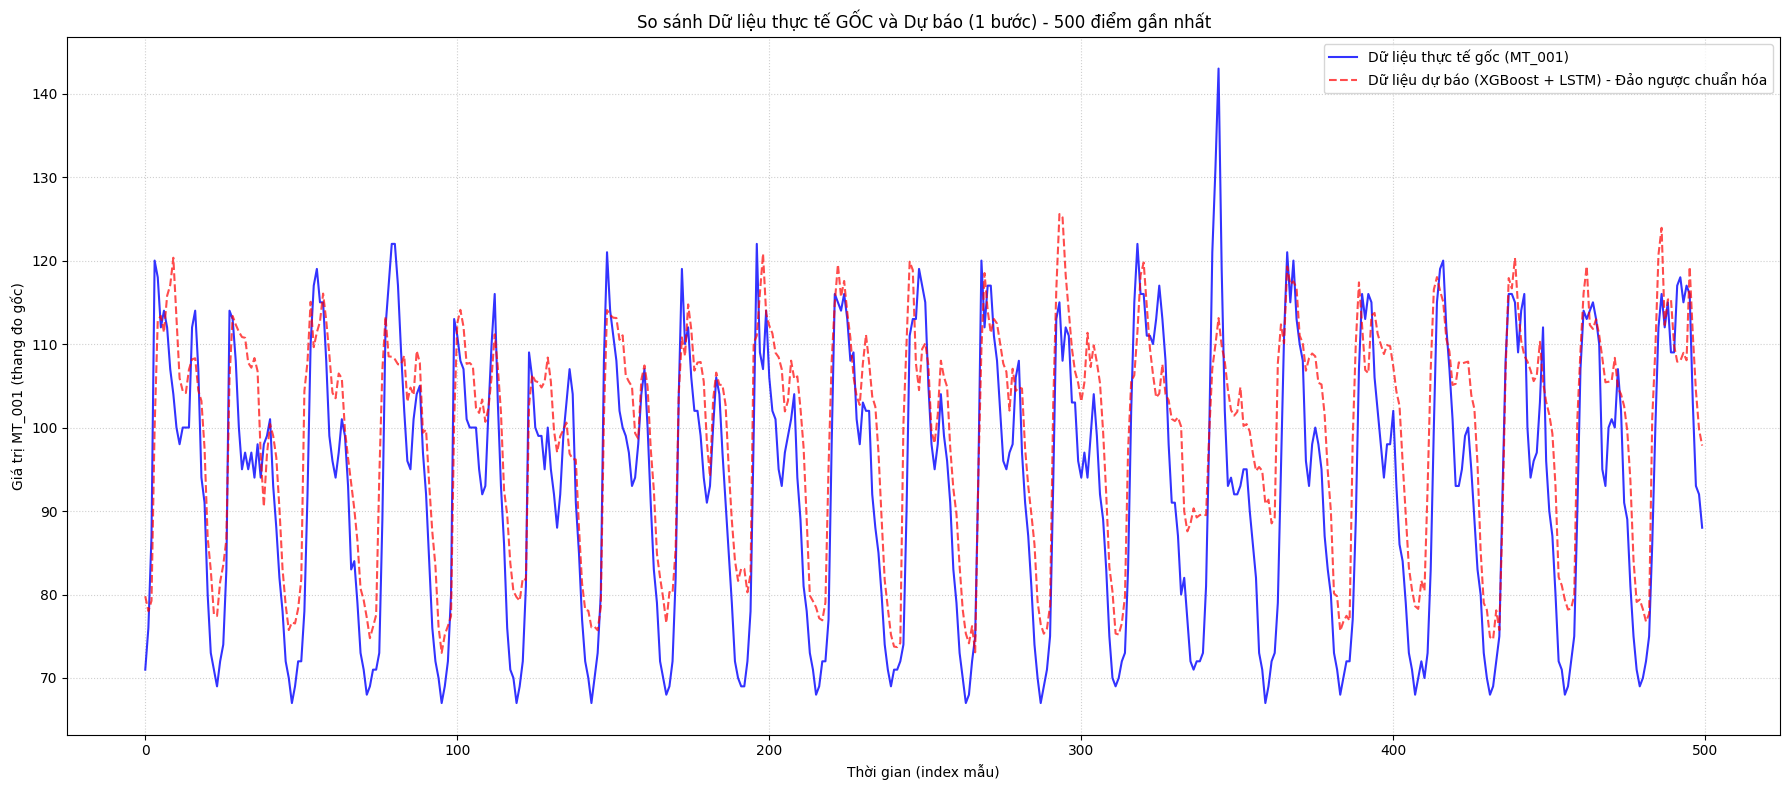

Đã vẽ biểu đồ so sánh dữ liệu thực tế gốc và dự báo sau đảo ngược chuẩn hóa.


In [11]:
# --- 8. Vẽ sơ đồ so sánh dữ liệu thực và dự báo (Dự báo một bước sau đảo ngược chuẩn hóa) ---
print("\n--- 8. Vẽ sơ đồ so sánh dữ liệu thực và dự báo (Dự báo một bước) ---")
num_points_to_plot = 500

plt.figure(figsize=(18, 8))
plt.plot(original_y_single_step[-num_points_to_plot:], label='Dữ liệu thực tế gốc (MT_001)', color='blue', alpha=0.8)
plt.plot(y_pred_single_step_inverted[-num_points_to_plot:], label='Dữ liệu dự báo (XGBoost + LSTM) - Đảo ngược chuẩn hóa', color='red', linestyle='--', alpha=0.7)
plt.title(f'So sánh Dữ liệu thực tế GỐC và Dự báo (1 bước) - {num_points_to_plot} điểm gần nhất')
plt.xlabel('Thời gian (index mẫu)')
plt.ylabel('Giá trị MT_001 (thang đo gốc)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("Đã vẽ biểu đồ so sánh dữ liệu thực tế gốc và dự báo sau đảo ngược chuẩn hóa.")


In [12]:
# --- Các bước tiếp theo (Dự báo đa bước) ---
print("\n--- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) ---")
def create_multistep_supervised_data(data, target_column='MT_001', window_size=24, horizon=12):
    X, y = [], []
    target_series = data[target_column].values
    for i in range(window_size, len(data) - horizon):
        X.append(data.iloc[i-window_size:i].values)
        y.append(target_series[i:i+horizon])
    return np.array(X), np.array(y)

X_12, y_12 = create_multistep_supervised_data(reduced_df, window_size=24, horizon=12)
X_24, y_24 = create_multistep_supervised_data(reduced_df, window_size=24, horizon=24)
X_36, y_36 = create_multistep_supervised_data(reduced_df, window_size=24, horizon=36)
X_48, y_48 = create_multistep_supervised_data(reduced_df, window_size=24, horizon=48)



--- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) ---


In [13]:
print("Đã tạo dữ liệu cho các horizon 12, 24, 36, 48.")
print(f"Shape of X_12: {X_12.shape}, y_12: {y_12.shape}")
print(f"Shape of X_24: {X_24.shape}, y_24: {y_24.shape}")
print(f"Shape of X_36: {X_36.shape}, y_36: {y_36.shape}")
print(f"Shape of X_48: {X_48.shape}, y_48: {y_48.shape}")

print("\n--- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước trên toàn bộ dữ liệu ---")

def extract_lstm_features(X, input_size, model=None):
    if model is None:
        model = LSTMFeatureExtractor(input_size)
    model.eval()
    with torch.no_grad():
        return model(torch.tensor(X, dtype=torch.float32)).numpy()

features_12 = extract_lstm_features(X_12, input_size=X_12.shape[2], model=lstm_extractor)
features_24 = extract_lstm_features(X_24, input_size=X_24.shape[2], model=lstm_extractor)
features_36 = extract_lstm_features(X_36, input_size=X_36.shape[2], model=lstm_extractor)
features_48 = extract_lstm_features(X_48, input_size=X_48.shape[2], model=lstm_extractor)
print("Đặc trưng LSTM cho dự báo đa bước đã được trích xuất.")


Đã tạo dữ liệu cho các horizon 12, 24, 36, 48.
Shape of X_12: (26268, 24, 51), y_12: (26268, 12)
Shape of X_24: (26256, 24, 51), y_24: (26256, 24)
Shape of X_36: (26244, 24, 51), y_36: (26244, 36)
Shape of X_48: (26232, 24, 51), y_48: (26232, 48)

--- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước trên toàn bộ dữ liệu ---
Đặc trưng LSTM cho dự báo đa bước đã được trích xuất.


In [14]:
def train_xgboost_multioutput_full_data(X, y):
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
    model.fit(X, y)
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return model, mse, mae

model_12, mse_12, mae_12 = train_xgboost_multioutput_full_data(features_12, y_12)
model_24, mse_24, mae_24 = train_xgboost_multioutput_full_data(features_24, y_24)
model_36, mse_36, mae_36 = train_xgboost_multioutput_full_data(features_36, y_36)
model_48, mse_48, mae_48 = train_xgboost_multioutput_full_data(features_48, y_48)

print("\n--- Kết quả Đánh giá Dự báo Đa Bước (trên toàn bộ dữ liệu CHUẨN HÓA) ---")
print(f"Horizon 12 - MSE: {mse_12:.4f}, MAE: {mae_12:.4f}")
print(f"Horizon 24 - MSE: {mse_24:.4f}, MAE: {mae_24:.4f}")
print(f"Horizon 36 - MSE: {mse_36:.4f}, MAE: {mae_36:.4f}")
print(f"Horizon 48 - MSE: {mse_48:.4f}, MAE: {mae_48:.4f}")

print("\nQuá trình hoàn tất.")


--- Kết quả Đánh giá Dự báo Đa Bước (trên toàn bộ dữ liệu CHUẨN HÓA) ---
Horizon 12 - MSE: 0.2540, MAE: 0.3534
Horizon 24 - MSE: 0.2621, MAE: 0.3545
Horizon 36 - MSE: 0.2725, MAE: 0.3615
Horizon 48 - MSE: 0.2758, MAE: 0.3623

Quá trình hoàn tất.
